In [1]:
# !pip install --upgrade tensorflow scikit-learn numpy
import tensorflow as tf
import numpy as np
import os
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil
import random
from tensorflow.keras import layers, models, Input
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

In [ ]:
# DATASET_PATH = '/kaggle/input/sampahh/dataset'
DATASET_PATH = '../dataset'
OUTPUT_PATH = 'Dataset_Split'
MAX_SAMPLES = 3000

TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

if not (abs(TRAIN_RATIO + VAL_RATIO + TEST_RATIO - 1.0) < 1e-9):
    raise ValueError("Total rasio harus 1.0")

def split_dataset(data_dir, output_dir, train_ratio, val_ratio, test_ratio, max_samples):

    for split in ['train', 'validation', 'test']:
        split_path = os.path.join(output_dir, split)
        if os.path.exists(split_path):
            shutil.rmtree(split_path)
        os.makedirs(split_path, exist_ok=True)

    classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

    if not classes:
        print(f"Error: Tidak ditemukan folder kelas di dalam {data_dir}")
        return


    for class_name in classes:
        class_path = os.path.join(data_dir, class_name)
        
        files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        random.shuffle(files)
        
        original_count = len(files)
        
        if original_count > max_samples:
            print(f"Kelas '{class_name}' memiliki {original_count} file. Kurangin menjadi {max_samples}...")
            files = files[:max_samples]
        

        total_files = len(files) 
        
        train_count = int(total_files * train_ratio)
        val_count = int(total_files * val_ratio)
        test_count = total_files - train_count - val_count
        
        if total_files > 0 and train_count == 0:
            print(f"Peringatan: Kelas {class_name} memiliki terlalu sedikit data untuk pembagian yang akurat.")
            
        train_files = files[:train_count]
        val_files = files[train_count : train_count + val_count]
        test_files = files[train_count + val_count :]

        print(f"--- Kelas: {class_name} ---")
        print(f"   Asli: {original_count} -> Dipakai: {total_files}")
        print(f"   Train: {len(train_files)}")
        print(f"   Validation: {len(val_files)}")
        print(f"   Test: {len(test_files)}")


        def copy_files(file_list, split_name):
            destination_dir = os.path.join(output_dir, split_name, class_name)
            os.makedirs(destination_dir, exist_ok=True) 
            
            for f in file_list:
                src_file = os.path.join(class_path, f)
                dst_file = os.path.join(destination_dir, f)
                try:
                    shutil.copy2(src_file, dst_file)
                except Exception as e:
                    print(f"Gagal menyalin {f}: {e}")

        copy_files(train_files, 'train')
        copy_files(val_files, 'validation')
        copy_files(test_files, 'test')
        
    print("\n aman")
    print(f"Dataset yang telah dibagi tersimpan di: {OUTPUT_PATH}")


split_dataset(DATASET_PATH, OUTPUT_PATH, TRAIN_RATIO, VAL_RATIO, TEST_RATIO, MAX_SAMPLES)

Kelas 'cardboard' memiliki 3249 file. Kurangin menjadi 3000...
--- Kelas: cardboard ---
   Asli: 3249 -> Dipakai: 3000
   Train: 2400
   Validation: 300
   Test: 300
--- Kelas: E-waste ---
   Asli: 2918 -> Dipakai: 2918
   Train: 2334
   Validation: 291
   Test: 293
Kelas 'Glass' memiliki 4150 file. Kurangin menjadi 3000...
--- Kelas: Glass ---
   Asli: 4150 -> Dipakai: 3000
   Train: 2400
   Validation: 300
   Test: 300
--- Kelas: metal ---
   Asli: 2808 -> Dipakai: 2808
   Train: 2246
   Validation: 280
   Test: 282
Kelas 'Organic Waste' memiliki 3035 file. Kurangin menjadi 3000...
--- Kelas: Organic Waste ---
   Asli: 3035 -> Dipakai: 3000
   Train: 2400
   Validation: 300
   Test: 300
--- Kelas: paper ---
   Asli: 2730 -> Dipakai: 2730
   Train: 2184
   Validation: 273
   Test: 273
Kelas 'plastic' memiliki 3884 file. Kurangin menjadi 3000...
--- Kelas: plastic ---
   Asli: 3884 -> Dipakai: 3000
   Train: 2400
   Validation: 300
   Test: 300
Kelas 'shoes' memiliki 3954 file. Kurangi

In [3]:
base_dir = '/kaggle/working/Dataset_Split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')

datagen = ImageDataGenerator(rescale=1./255)


train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)


val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

class_weights_val = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
weights = dict(enumerate(class_weights_val))

print(f"\nJumlah Kelas terdeteksi: {train_generator.num_classes}")
print("Class Weights:", weights)

Found 22392 images belonging to 10 classes.
Found 2797 images belonging to 10 classes.

Jumlah Kelas terdeteksi: 10
Class Weights: {0: 0.9593830334190231, 1: 0.933, 2: 0.9680933852140078, 3: 0.933, 4: 0.933, 5: 0.9969723953695458, 6: 1.0252747252747252, 7: 0.933, 8: 0.933, 9: 1.7028136882129277}


In [4]:
labels = list(train_generator.class_indices.keys())
print(labels)


['E-waste', 'Glass', 'Organic Waste', 'Textiles', 'cardboard', 'metal', 'paper', 'plastic', 'shoes', 'trash']


In [5]:
import json

with open("labels.json", "w") as f:
    json.dump(labels, f)

In [6]:


def residual_block(x, filters, stride=1):
    shortcut = x

    if stride > 1 or x.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), strides=stride, padding="same")(x)

    x = layers.Conv2D(filters, (3, 3), strides=stride, padding="same", activation="relu")(x)
    x = layers.Conv2D(filters, (3, 3), strides=1, padding="same")(x)

    x = layers.add([x, shortcut])
    
    x = layers.Activation("relu")(x)
    
    return x

inputs = Input(shape=(224, 224, 3))

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

x = data_augmentation(inputs)

x = layers.Conv2D(64, (7, 7), strides=2, padding="same", activation="relu")(x)
x = layers.MaxPooling2D((3, 3), strides=2, padding="same")(x)
x = residual_block(x, filters=64, stride=1)
x = residual_block(x, filters=64, stride=1)
x = residual_block(x, filters=128, stride=2)
x = residual_block(x, filters=128, stride=1)

x = residual_block(x, filters=256, stride=2)
x = residual_block(x, filters=256, stride=1)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = models.Model(inputs, outputs, name="ResNet_Custom")

model.summary()

I0000 00:00:1764855389.318910      79 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764855389.319592      79 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "ResNet_Custom"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ sequential[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     36,928 │ conv2d_1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 56, 56,    │          0 │ conv2d_2[0][0],   │
│                     │ 64)               │            │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 56, 56,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     36,928 │ conv2d_3[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 56, 56,    │          0 │ conv2d_4[0][0],   │
│                     │ 64)               │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 56, 56,    │          0 │ add_1[0][0]       │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28,    │     73,856 │ activation_1[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 28, 28,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 28, 28,    │      8,320 │ activation_1[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 28, 28,    │          0 │ conv2d_7[0][0],   │
│                     │ 128)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 28, 28,    │          0 │ add_2[0][0]     

 Total params: 2,848,906 (10.87 MB)

 Trainable params: 2,848,906 (10.87 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'model_terbaik_balanced.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)

In [8]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=200,
    callbacks=[early_stopping, checkpoint],
    class_weight=weights,            
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200


I0000 00:00:1764855397.310103     129 cuda_dnn.cc:529] Loaded cuDNN version 90300


700/700 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.2127 - loss: 2.0959
Epoch 1: val_loss improved from inf to 1.75520, saving model to model_terbaik_balanced.keras
700/700 ━━━━━━━━━━━━━━━━━━━━ 76s 97ms/step - accuracy: 0.2127 - loss: 2.0957 - val_accuracy: 0.4047 - val_loss: 1.7552
Epoch 2/200
700/700 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.3646 - loss: 1.7731
Epoch 2: val_loss improved from 1.75520 to 1.58955, saving model to model_terbaik_balanced.keras
700/700 ━━━━━━━━━━━━━━━━━━━━ 71s 101ms/step - accuracy: 0.3646 - loss: 1.7730 - val_accuracy: 0.4558 - val_loss: 1.5895
Epoch 3/200
700/700 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.4387 - loss: 1.6025
Epoch 3: val_loss did not improve from 1.58955
700/700 ━━━━━━━━━━━━━━━━━━━━ 69s 98ms/step - accuracy: 0.4388 - loss: 1.6025 - val_accuracy: 0.4272 - val_loss: 1.6403
Epoch 4/200
700/700 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.4815 - loss: 1.4863
Epoch 4: val_loss improved from 1.58955 to 1.46415, saving model 

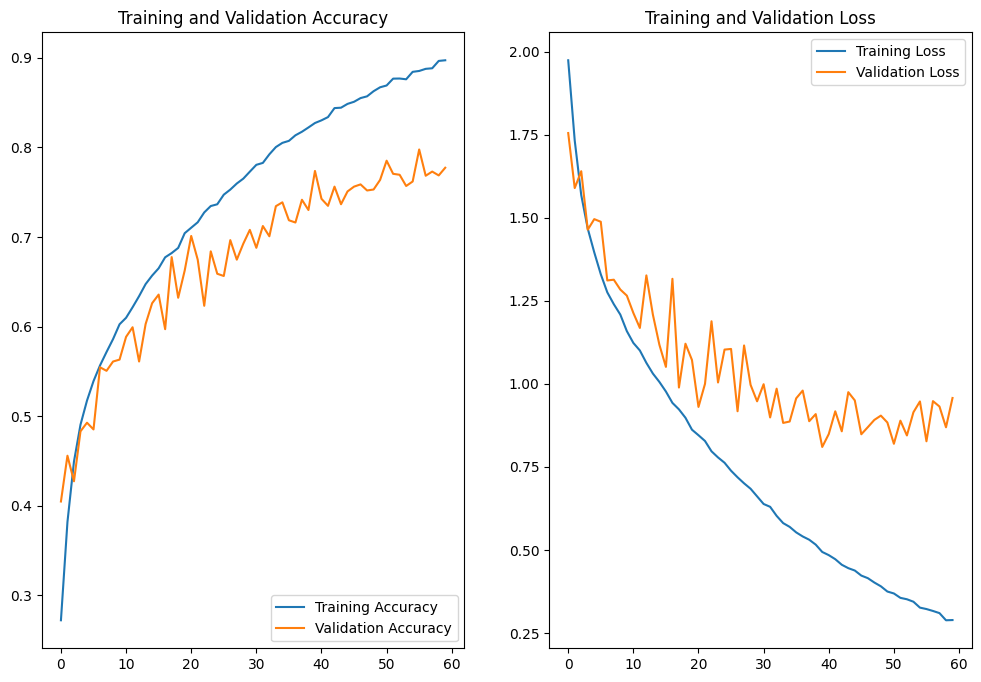

In [10]:
model = load_model("model_terbaik_balanced.keras")

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(60)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Memuat model dari model_terbaik_balanced.keras...
Sedang melakukan prediksi pada data validasi...
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step


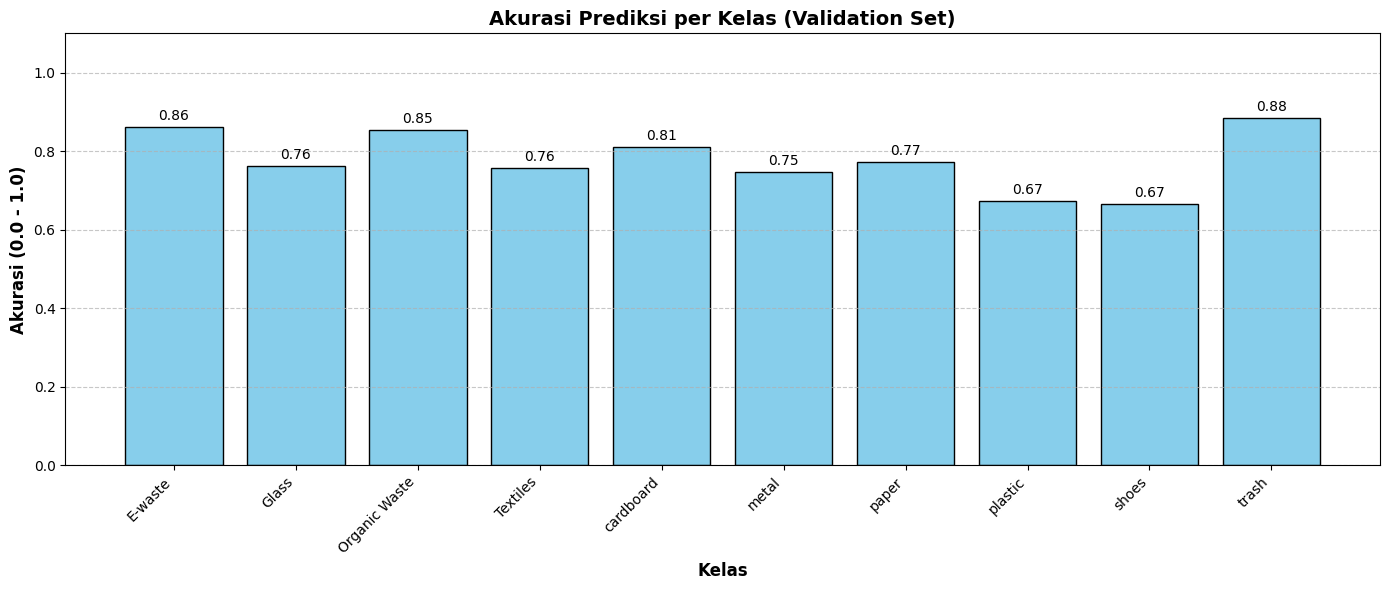


--- Detail Laporan Klasifikasi ---
               precision    recall  f1-score   support

      E-waste       0.66      0.86      0.75       291
        Glass       0.85      0.76      0.80       300
Organic Waste       0.83      0.85      0.84       289
     Textiles       0.85      0.76      0.80       300
    cardboard       0.86      0.81      0.83       300
        metal       0.63      0.75      0.68       280
        paper       0.75      0.77      0.76       273
      plastic       0.83      0.67      0.75       300
        shoes       0.78      0.67      0.72       300
        trash       0.78      0.88      0.83       164

     accuracy                           0.77      2797
    macro avg       0.78      0.78      0.78      2797
 weighted avg       0.78      0.77      0.77      2797



In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model

model_path = 'model_terbaik_balanced.keras' 
print(f"Memuat model dari {model_path}...")
model = load_model(model_path)
val_generator.reset()


print("Sedang melakukan prediksi pada data validasi...")
y_pred_prob = model.predict(val_generator, verbose=1)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = val_generator.classes
class_names = list(val_generator.class_indices.keys())


cm = confusion_matrix(y_true, y_pred)
class_accuracy = cm.diagonal() / cm.sum(axis=1)

plt.figure(figsize=(14, 6))
bars = plt.bar(class_names, class_accuracy, color='skyblue', edgecolor='black')

plt.xlabel('Kelas', fontsize=12, fontweight='bold')
plt.ylabel('Akurasi (0.0 - 1.0)', fontsize=12, fontweight='bold')
plt.title('Akurasi Prediksi per Kelas (Validation Set)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right') 
plt.ylim(0, 1.1) 
plt.grid(axis='y', linestyle='--', alpha=0.7)


for bar, acc in zip(bars, class_accuracy):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.01, 
             f'{acc:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


print("\n--- Detail Laporan Klasifikasi ---")
print(classification_report(y_true, y_pred, target_names=class_names))

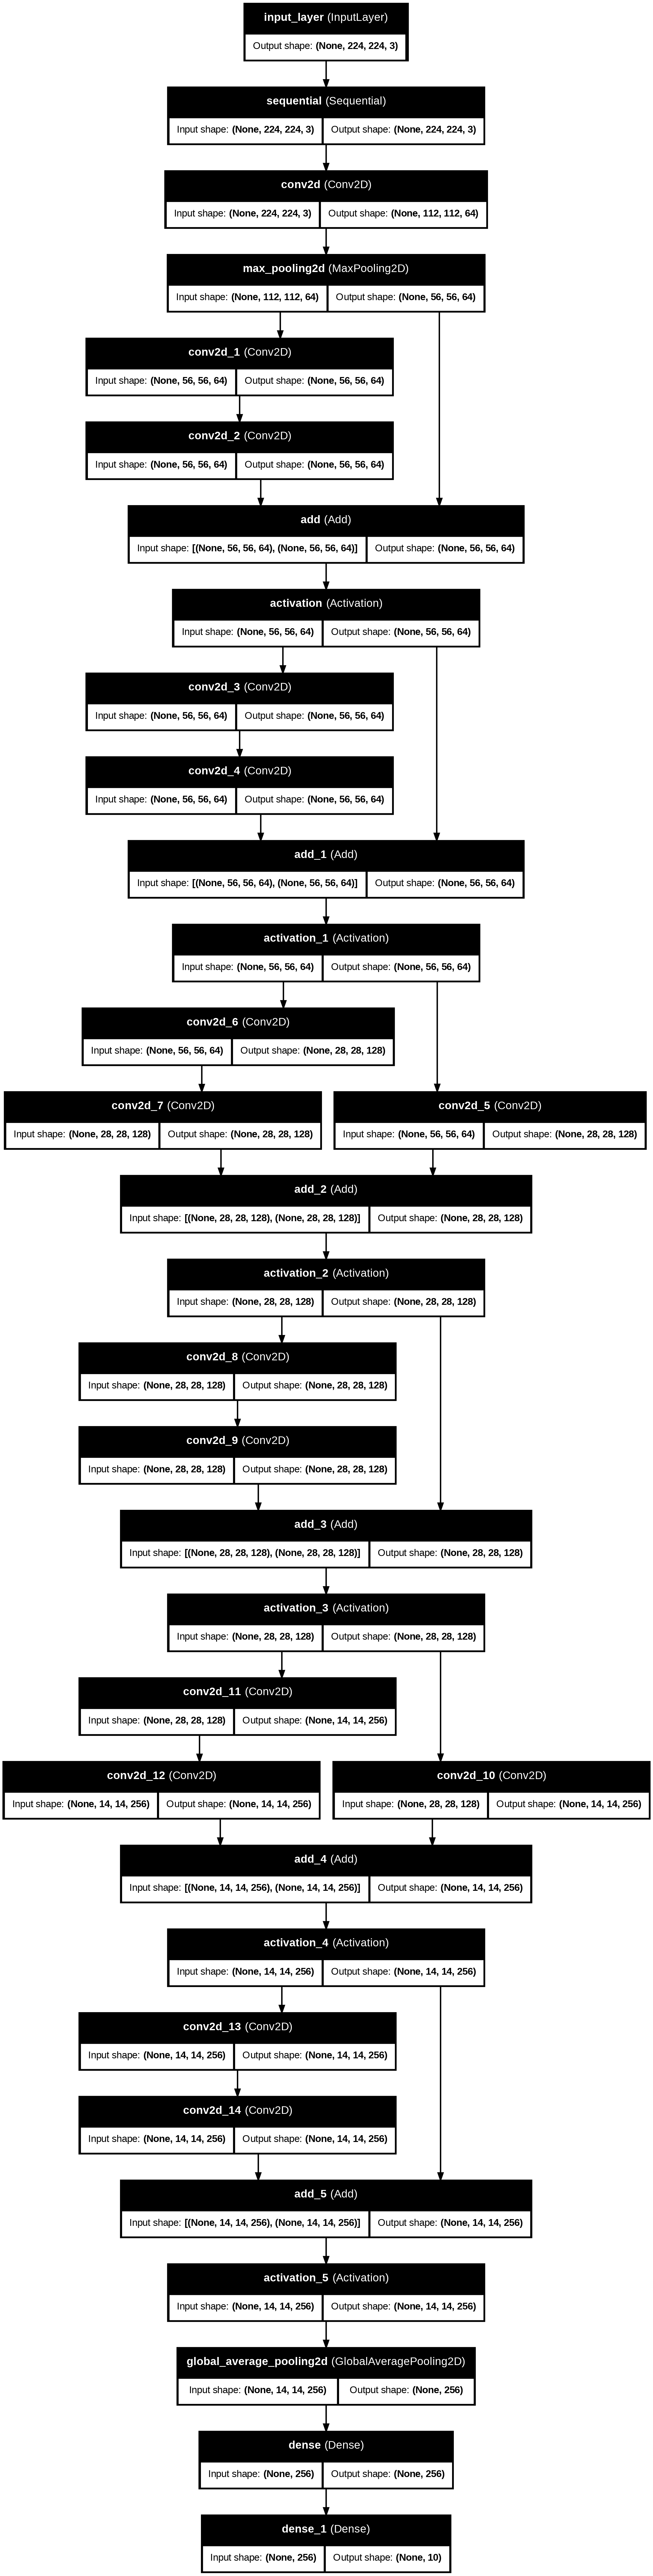

In [12]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
